# Dynamic System Identification

In [4]:
# import
import numpy as np
import time, random, math, scipy, datetime, cv2
import matplotlib.pyplot as plt
import mediapy as media
import pandas as pd
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import ipywidgets as widgets
from IPython.display import display
from scipy.optimize import differential_evolution
from pathlib import Path
import sys, rootpath
root_dir = rootpath.detect()   # Get the root directory of the project (.git)
sys.path.append(str(Path(root_dir)))    # For importing modules in the project
from utils.experiment import MujocoExperiment

In [5]:
# Tools
def smooth_data(data, window_size=5, axis=-1):
    pad_width = window_size // 2
    # create the padded axis
    _dim = data.ndim
    _paddle_before_after = [(0,0) for _ in range(_dim)]
    _paddle_before_after[-1] = (pad_width, window_size-pad_width-1)     # the size = data_size + pad_size - window_size + 1
    padded_data = np.pad(data, _paddle_before_after, mode='edge')
    
    return np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'), 
        axis=axis,
        arr=padded_data
    )

In [6]:
# Process the real data
# Original data: angles are in degrees, containing pressure1_start, pressure2_start, pressure1_end, pressure2_end, relative_time, thigh_theta21, calf_theta32
start_step_time = 5
pressure_group_num = 6
data_real_path = root_dir + "/src/validation_physical/dynamic/data/ToCenter_2025-02-20_21-06-20_A2B_data.csv"
data_real = pd.read_csv(data_real_path)
data_real["experiment_group"] = data_real.groupby(["pressure1_start", "pressure2_start", "pressure1_end", 
                                     "pressure2_end"]).ngroup()         # 0-35 Groups

expdata_real_lineInterp = []
expdata_real_splineInterp = []
expdata_real_origin = []     # original data
for group_id in data_real["experiment_group"].unique():
    # group_data_real is the data after the step starts
    group_data_real = data_real[data_real["experiment_group"]==group_id]
    group_data_real = group_data_real[group_data_real["relative_time"]>=start_step_time]

    # get the pressure setup of this group
    pressure1_start = group_data_real["pressure1_start"].iloc[0]    # visit data of this group
    pressure2_start = group_data_real["pressure2_start"].iloc[0]
    pressure1_end = group_data_real["pressure1_end"].iloc[0]
    pressure2_end = group_data_real["pressure2_end"].iloc[0]

    # get the data of this group
    time_real = np.array(group_data_real["relative_time"]-start_step_time)
    theta1_real = np.array(group_data_real["thigh_theta21"])
    theta2_real = np.array(group_data_real["calf_theta32"])

    # Interpolation, using linear interpolation and spline interpolation (k=3)
    t_intervel = np.linspace(0, 4, 401)
    delta_t = time_real[1] - time_real[0]

    theta1_real_lineInterp = np.interp(t_intervel, time_real, theta1_real)
    theta2_real_lineInterp = np.interp(t_intervel, time_real, theta2_real)
    theta1_spline = scipy.interpolate.make_interp_spline(time_real, theta1_real, k=3)
    theta2_spline = scipy.interpolate.make_interp_spline(time_real, theta2_real, k=3)
    theta1_real_splineInterp = theta1_spline(t_intervel)
    theta2_real_splineInterp = theta2_spline(t_intervel) 

    # stack all data and record in list
    expdata_real_lineInterp_one = np.stack((t_intervel, theta1_real_lineInterp, theta2_real_lineInterp), axis=0)
    expdata_real_splineInterp_one = np.stack((t_intervel, theta1_real_splineInterp, theta2_real_splineInterp), axis=0)
    expdata_real_origin_one = np.stack((time_real, theta1_real, theta2_real), axis=0)
    expdata_real_lineInterp.append(expdata_real_lineInterp_one)
    expdata_real_splineInterp.append(expdata_real_splineInterp_one)
    expdata_real_origin.append(expdata_real_origin_one)

# convert to numpy array
expdata_real_lineInterp = np.array(expdata_real_lineInterp)
expdata_real_splineInterp = np.array(expdata_real_splineInterp)
# expdata_real_origin = np.array(expdata_real_origin)       # for the length of each group is different, so we can't use np.array

print(f"expdata_real_lineInterp.shape: {expdata_real_lineInterp.shape}")
print(f"expdata_real_splineInterp.shape: {expdata_real_splineInterp.shape}")
print(f"expdata_real_origin.len: {len(expdata_real_origin)}")

# above data is all response of [init pressures], however, we need to select the effective data for the experiment.
data = pd.read_csv(root_dir + "/src/validation_physical/static/data/real_static_state/real(effective)_StaticPoint_6group.csv")
P1_array = data['P1 (kPa)'].values
P2_array = data['P2 (kPa)'].values
theta1_array = data['theta1 (deg)'].values
theta2_array = data['theta2 (deg)'].values

# theta1_array = np.array(theta1_array, dtype=np.float32)*np.pi/180 
# theta2_array = np.array(theta2_array, dtype=np.float32)*np.pi/180 
P1_array = np.array(P1_array, dtype=np.float32)*1000
P2_array = np.array(P2_array, dtype=np.float32)*1000

effective_idx = np.array((P1_array/10000) * pressure_group_num + (P2_array/10000), dtype=np.int16)
print("effective_idx: ", effective_idx)

# effective_idx = [19]  # TODO 30,10

expdata_real_lineInterp_effective = expdata_real_lineInterp[effective_idx]
expdata_real_splineInterp_effective = expdata_real_splineInterp[effective_idx]
expdata_real_origin_effective = [expdata_real_origin[i] for i in effective_idx]
# The shape of data is (13, 3, 401), namely (n_experiments, t-theta1-theta2, n_timesteps)
print(f"expdata_real_lineInterp_effective Shape = {expdata_real_lineInterp_effective.shape}")
print(f"expdata_real_splineInterp_effective Shape = {expdata_real_splineInterp_effective.shape}")
print(f"expdata_real_origin_effective Len = {len(expdata_real_origin_effective)}")


expdata_real_lineInterp.shape: (36, 3, 401)
expdata_real_splineInterp.shape: (36, 3, 401)
expdata_real_origin.len: 36
effective_idx:  [ 0  1  2  3  6  7  8 12 13 18 19 24 30]
expdata_real_lineInterp_effective Shape = (13, 3, 401)
expdata_real_splineInterp_effective Shape = (13, 3, 401)
expdata_real_origin_effective Len = 13


In [7]:
# show the real data
interest_group_slider = widgets.IntSlider(value=0, min=0, max=len(expdata_real_lineInterp_effective)-1, step=1, description='Interest Group:')
window_size_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='Window Size:')

def update_plot(interest_group, window_size=5):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    expdata_effective = expdata_real_lineInterp_effective[interest_group]
    ax[0].plot(expdata_effective[0], expdata_effective[1], color='blue', linestyle=':', alpha=0.3, label=r'Line Interpolated $\theta_1$')
    ax[0].plot(expdata_effective[0], expdata_effective[2], color='orange', linestyle=':', alpha=0.3, label=r'Line Interpolated $\theta_2$')

    expdata_effective = expdata_real_splineInterp_effective[interest_group]
    ax[0].plot(expdata_effective[0], expdata_effective[1], color='green', alpha=0.3, linestyle="--", label=r'Spline Interpolated $\theta_1$')
    ax[0].plot(expdata_effective[0], expdata_effective[2], color='red', alpha=0.3, linestyle="--", label=r'Spline Interpolated $\theta_2$')

    expdata_effective = expdata_real_origin_effective[interest_group]
    ax[0].plot(expdata_effective[0], expdata_effective[1], color='blue', alpha=0.3, linestyle='-', label=r'Real $\theta_1$')
    ax[0].plot(expdata_effective[0], expdata_effective[2], color='orange', alpha=0.3, linestyle='-', label=r'Real $\theta_2$')

    # plot the smooth data of the expdata_real_lineInterp_effective
    expdata_effective = expdata_real_lineInterp_effective[interest_group]
    theta1_smooth = smooth_data(expdata_effective[1][np.newaxis, :], window_size=window_size)[0]
    theta2_smooth = smooth_data(expdata_effective[2][np.newaxis, :], window_size=window_size)[0]
    # print(theta1_smooth.shape)
    ax[0].plot(expdata_effective[0], theta1_smooth, color='blue', linestyle='-', label=r'Smooth Line Interpolated $\theta_1$')
    ax[0].plot(expdata_effective[0], theta2_smooth, color='orange', linestyle='-', label=r'Smooth Line Interpolated $\theta_2$')

    ax[0].set_title('Real Data, Line Interpolated and Spline Interpolated Data')
    # ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Angle (deg)')
    ax[0].set_xlim(0, 2)
    ax[0].set_ylim(0, 120)
    ax[0].legend(loc='upper right', fontsize='medium', frameon=True)
    ax[0].grid()
    plt.tight_layout()

    velocity1 = np.gradient(theta1_smooth, axis=-1)/delta_t
    velocity2 = np.gradient(theta2_smooth, axis=-1)/delta_t

    ax[1].plot(expdata_effective[0], velocity1, color='blue', linestyle='-', label=r'Velocity $\theta_1$')
    ax[1].plot(expdata_effective[0], velocity2, color='orange', linestyle='-', label=r'Velocity $\theta_2$')
    ax[1].set_title('Velocity of Angles')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Velocity (deg/s)')
    ax[1].set_xlim(0, 2)
    ax[1].set_ylim(-100, 100)
    ax[1].legend(loc='upper right', fontsize='medium', frameon=True)
    ax[1].grid()

    # tight
    plt.tight_layout()
    plt.show()

widgets.interactive(update_plot, interest_group=interest_group_slider, window_size=window_size_slider)


interactive(children=(IntSlider(value=0, description='Interest Group:', max=12), IntSlider(value=5, descriptio…

(13, 3, 401)


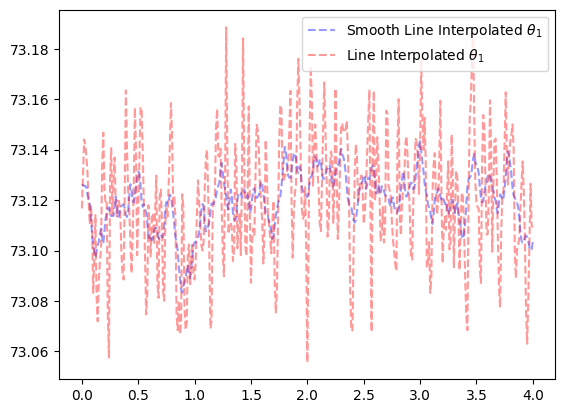

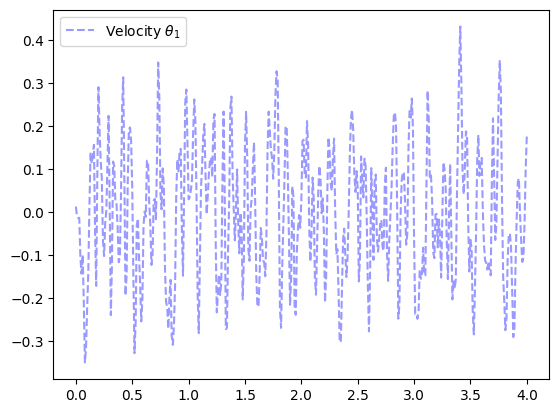

In [8]:
# the realdata used
expdata_real_lineInterp_effective_smooth = smooth_data(expdata_real_lineInterp_effective, window_size=11, axis=-1)
velocity_real_lineInterp_effective_presmooth = np.gradient(expdata_real_lineInterp_effective_smooth, axis=-1)/delta_t

print(expdata_real_lineInterp_effective_smooth.shape)
plt.plot(expdata_real_lineInterp_effective[0, 0], expdata_real_lineInterp_effective_smooth[0, 1], color='blue', alpha=0.4, linestyle='--', label=r'Smooth Line Interpolated $\theta_1$')
plt.plot(expdata_real_lineInterp_effective[0, 0], expdata_real_lineInterp_effective[0, 1], color='red', alpha=0.4, linestyle='--', label=r'Line Interpolated $\theta_1$')
plt.legend()

plt.figure()
plt.plot(expdata_real_lineInterp_effective[0, 0], velocity_real_lineInterp_effective_presmooth[0, 1], color='blue', alpha=0.4, linestyle='--', label=r'Velocity $\theta_1$')
plt.legend()


In [9]:
# Sim Data Collection

path = (root_dir + "/models/v2_4/urdf/dog2_4singleLeg_realconstrast.xml")
experiment_instance = MujocoExperiment(path)
para_init = {
    'stiffness_MAA': 203.9489, # TODO: from the static data
    'stiffness_BAA': 105.0733, # TODO
    'l10': 0.174,
    'l20': 0.2562,
    'damping_MAA': 11.34,
    'damping_BAA': 10.90,
    'c1_thigh': 0,
    'c2_calf': 0,
    's1': 0.000411,
    's2': 0.000324,
    'P1': 0,        # To be set
    'P2': 0,
    'P1_prime': 0.0,      
    'P2_prime': 0.0       # equal to F when s=1
}

# a function wrapper to run the experiment and return the results
def run_single_experiment(params, ifrender=False, sim="run", valveDynamics=False):
    """
    Run a single experiment with the given parameters.
    Args:
        params (dict): Dictionary of parameters to set for the experiment.
    Returns:
        time_sim (ndarray): Simulated time data.
        theta1_sim (ndarray): Simulated angle data for joint 1.
        theta2_sim (ndarray): Simulated angle data for joint 2.
        frames (list): List of frames generated during the simulation.
    """
    para = para_init.copy()
    for k, v in params.items():
        para[k] = v
    try:
        # Run the simulation
        time_step = 10
        duration_exp = 20
        if sim == "run":
            if valveDynamics:
                time_sim, theta1_sim, theta2_sim, frames, _, _, _pressure1, _pressure2 = experiment_instance.run_with_valve_dynamics(para, time_step=time_step, duration=duration_exp, ifrender=ifrender)
            else:
                time_sim, theta1_sim, theta2_sim, frames, _, _ = experiment_instance.run(para, time_step=time_step, duration=duration_exp, ifrender=ifrender)
        else:
            time_sim, theta1_sim, theta2_sim, frames, _, _ = experiment_instance.fastrun(para, time_step=time_step, duration=duration_exp, ifrender=ifrender)
        return time_sim, theta1_sim, theta2_sim, frames
    # ctrl C to quit
    except KeyboardInterrupt:
        pass


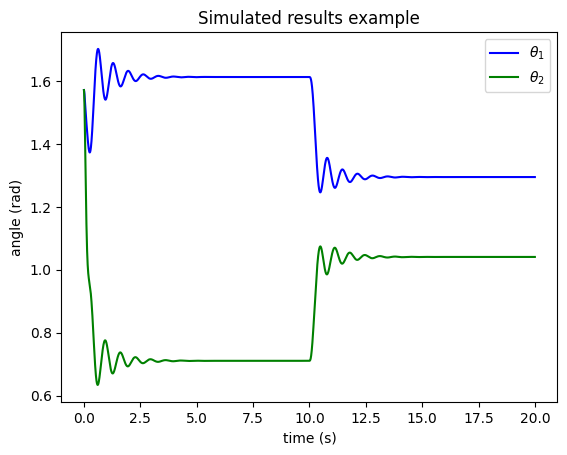

In [10]:
# example of sim results
para = para_init.copy()
para['P1'] = 20 * 1000
time_sim, theta1_sim, theta2_sim, frames = run_single_experiment(para, ifrender=False, valveDynamics=True)
plt.plot(time_sim, theta1_sim, color='blue', label=r'$\theta_1$')
plt.plot(time_sim, theta2_sim, color='green', label=r'$\theta_2$')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('angle (rad)')
plt.title('Simulated results example')
plt.show()

In [11]:
# init parameters
parameters_init = {
    'stiffness_MAA': 141.02960841103112,
    'stiffness_BAA': 113.79784850542735,
    'l10': 0.1740,
    'l20': 0.2526,
    'damping_MAA': 24.1515,
    'damping_BAA': 10.3101,
    's1': 0.0003538647203395966,
    's2': 0.0003466318012150854,
    'c1_thigh': 4.9746,
    'c2_calf': 0.3958,
    'P1': 0,        # to set from the experimental data
    'P2': 0,
    'P1_prime': 0.0,      
    'P2_prime': 0.0       # equal to F when s=1
}

In [12]:
typeExp = "onlyC"
global tic
tic = 0
t_bias = 10         # TODO

# define the error function
def error(param_list, mode="train", type=typeExp, sim="fastrun", t_bias=t_bias):
    global tic
    tic += 1
    global typeExp
    typeExp = type
    # print(f"tic: {tic}, typeExp: {typeExp}, mode: {mode}")
    if type == "dynamic":
      k1, k2, l10, l20, c1, c2, s1, s2, c1_thigh, c2_calf = param_list
    else: # static
      c1, c2, c1_thigh, c2_calf = param_list
      k1 = 203.9489
      k2 = 105.0733
      s1 = 0.000411
      s2 = 0.000324
      l10 = 0.1740
      l20 = 0.2562
    expdata_sim_all = []
    for p1, p2 in zip(P1_array[:], P2_array[:]):
      para = {
        'stiffness_MAA': k1,
        'stiffness_BAA': k2,
        'l10': l10,
        'l20': l20,
        'damping_MAA': c1,
        'damping_BAA': c2,
        's1': s1,
        's2': s2,
        'c1_thigh': c1_thigh,
        'c2_calf': c2_calf,
        'P1': p1,        # to set from the experimental data
        'P2': p2,
        'P1_prime': 0.0,
        'P2_prime': 0.0,
      }
      time_sim, theta1_sim, theta2_sim, frames = run_single_experiment(para, ifrender=False, sim=sim)
         
      time_sim = time_sim - t_bias
      t_intervel = np.linspace(0, 4, 401)
      theta1_sim_intervel = np.interp(t_intervel, time_sim, theta1_sim) * 180 / np.pi
      theta2_sim_intervel = np.interp(t_intervel, time_sim, theta2_sim) * 180 / np.pi

      expdata_sim = np.stack((t_intervel, theta1_sim_intervel, theta2_sim_intervel), axis=0)  # 3*401
      expdata_sim_all.append(expdata_sim)
    expdata_sim_all = np.array(expdata_sim_all)   # 13*3*401

    # Error of theta1 and theta2
    q_errorMat = expdata_sim_all - expdata_real_lineInterp_effective_smooth
    q_SE_mat = q_errorMat**2
    q_MSE_mat = np.mean(q_SE_mat, axis=2)   # along the time axis
    q_MSE_mat_overview = np.mean(q_MSE_mat, axis=0) # along the group axis
    q_MSE_sum = np.mean(q_MSE_mat_overview[1:]) # along the joint axis(MSE of theta1 plus MSE of theta2)

    # Error of angular velocity(vs velocity_real_lineInterp_effective_presmooth)
    qd_sim = np.gradient(expdata_sim_all, axis=-1)/delta_t
    qd_errorMat = qd_sim - velocity_real_lineInterp_effective_presmooth
    qd_SE_mat = qd_errorMat**2
    qd_MSE_mat = np.mean(qd_SE_mat, axis=2)
    qd_MSE_mat_overview = np.mean(qd_MSE_mat, axis=0)
    qd_MSE_sum = np.mean(qd_MSE_mat_overview[1:])   # along the joint axis(MSE of theta1 plus MSE of theta2)
    # print(f"q_MSE_sum: {q_MSE_sum:.4f}, qd_MSE_sum: {qd_MSE_sum:.4f}")
    velocity_sim_sign = np.where(qd_sim > 0, 1, -1)
    velocity_real_sign = np.where(velocity_real_lineInterp_effective_presmooth > 0, 1, -1)
    errorMat_velocity = np.where(velocity_sim_sign == velocity_real_sign, 0, 1)
    errorMat_velocity_sum = np.mean(errorMat_velocity, axis=0)  # along the group axis
    errorMat_velocity_sum = np.mean(errorMat_velocity_sum[1:])  # along the joint axis
    errorMat_velocity_sum_mean = np.mean(errorMat_velocity_sum)

    # error new
    # if type == "dynamic":
        # print(q_MSE_sum)
    print(f"[RMSE]: {np.sqrt(q_MSE_sum):.8f}")
    return q_MSE_sum + 100*errorMat_velocity_sum_mean
    # else:
    #     return np.mean(q_SE_mat[:, 1:, 0])

k1 = 203.9489
k2 = 105.0733
s1 = 0.000411
s2 = 0.000324

l10 = 0.1740
l20 = 0.2562

c1 = 10
c2 = 10

c1_thigh = 4.9746
c2_calf = 0.3958

# k1, k2, l10, l20, c1, c2, s1, s2, c1_thigh, c2_calf = params
para = [k1, k2, l10, l20, c1, c2, s1, s2, c1_thigh, c2_calf]
print(error(para, type="dynamic"))


[RMSE]: 12.46390414
191.53728168669764


In [ ]:
# TODO: DEBUG HERE!
para_i_ = [np.float64(188.27464544832503),
 np.float64(100.21723249341814),
 np.float64(0.17284013058639838),
 np.float64(0.2539684758834033),
 np.float64(9.410946988019155),
 np.float64(27.366915947621354),
 np.float64(0.0003586484247042384),
 np.float64(0.0003755826394215505),
 np.float64(0.507386056470603),
 np.float64(0.05767909515577111)]
error(para_i_, type="dynamic")

[RMSE]: 1.82207564


np.float64(39.32609812333933)

In [ ]:
#TODO:  DEBUG HERE!

In [13]:
%timeit error(para, type="dynamic")

[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
571 ms ± 43.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit error(para, type="dynamic", sim="fastrun")

[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
[RMSE]: 12.46390414
553 ms ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# optimization

from functools import partial

error_allparams_withoutValves = partial(error, mode="train", type="dynamic", t_bias=10)

global time_start, time_epi_start, epi
time_start = time.time()
time_epi_start = time.time()
epi = 0

def callback(xk, convergence):
    global time_epi_start, time_epi_start, epi
    epi += 1
    time_cost_epi = time.time() - time_epi_start
    time_epi_start = time.time()
    print(f"Epoch: {epi}, Time/epoch: {time_cost_epi:.2f}s, convergence={convergence:.4f}, MSE={error_allparams_withoutValves(xk):.4f}")
    print(f"k1={xk[0]:.4f}, k2={xk[1]:.4f}, l10={xk[2]:.4f}, l20={xk[3]:.4f}, c1={xk[4]:.4f}, c2={xk[5]:.4f}, s1={xk[6]:.8f}, s2={xk[7]:.8f}, c1_thigh={xk[8]:.4f}, c2_calf={xk[9]:.4f}")
    print(f"Time/epoch: {time_cost_epi:.2f}s")
    # return False    # False means continue, True means stop

try:
    bounds = [(k1*0.9, k1*1.5), (k2*0.9, k2*1.5), (l10*0.9, l10*1.1), (l20*0.9, l20*1.1), (0, 30), (0, 30), (s1*0.5, s1*1.5), (s2*0.5, s2*1.5), (0, 5), (0, 5)] 
    result = differential_evolution(error_allparams_withoutValves, bounds, strategy='best1bin', maxiter=10000, disp=True, callback=callback, popsize=2, seed=42)
    k1_opt, k2_opt, l10_opt, l20_opt, c1_opt, c2_opt, s1_opt, s2_opt, c1_thigh_opt, c2_calf_opt = result.x
    print(f"Optimal k1={k1_opt:.4f}, k2={k2_opt:.4f}, l10={l10_opt:.4f}, l20={l20_opt:.4f}, c1={c1_opt:.4f}, c2={c2_opt:.4f}, s1={s1_opt:.8f}, s2={s2_opt:.8f}, c1_thigh={c1_thigh_opt:.4f}, c2_calf={c2_calf_opt:.4f}, MSE={result.fun:.4f}")
    print(f"Error: {error_allparams_withoutValves([k1_opt, k2_opt, l10_opt, l20_opt, c1_opt, c2_opt, s1_opt, s2_opt, c1_thigh_opt, c2_calf_opt])}")
    time_cost = time.time() - time_start
    print(f"Time Cost: {time_cost:.2f}s")
except KeyboardInterrupt:
    print("Exit")


[RMSE]: 7.43373099
[RMSE]: 8.48047322
[RMSE]: 20.96491318
[RMSE]: 11.40711537
[RMSE]: 11.62433433
[RMSE]: 14.21168325
[RMSE]: 6.09470593
[RMSE]: 9.98506587
[RMSE]: 8.81060260
[RMSE]: 10.85704719
[RMSE]: 8.23724706
[RMSE]: 8.19935599
[RMSE]: 7.61842156
[RMSE]: 7.41282200
[RMSE]: 12.28028284
[RMSE]: 12.50032799
[RMSE]: 17.11012411
[RMSE]: 8.17716662
[RMSE]: 8.30952076
[RMSE]: 17.07064491
[RMSE]: 14.77644449
[RMSE]: 6.80419317
[RMSE]: 16.56896392
[RMSE]: 8.59638042
[RMSE]: 7.89782469
[RMSE]: 7.93793251
[RMSE]: 8.97453742
[RMSE]: 16.79703475
[RMSE]: 9.04843230
[RMSE]: 9.53316366
[RMSE]: 9.60459774
[RMSE]: 7.74902550
[RMSE]: 8.03679645
[RMSE]: 6.70177231
[RMSE]: 12.70563895
[RMSE]: 6.75607124
[RMSE]: 15.03802783
[RMSE]: 7.75517817
[RMSE]: 6.26068822
[RMSE]: 8.73543356
differential_evolution step 1: f(x)= 73.73665463864029
[RMSE]: 6.09470593
Epoch: 1, Time/epoch: 23.36s, convergence=0.0203, MSE=73.7367
k1=189.7984, k2=139.4904, l10=0.1685, l20=0.2506, c1=20.9144, c2=6.9938, s1=0.00031007, s2

In [ ]:
# Test: show all the case
para = [k1_opt, k2_opt, l10_opt, l20_opt, c1_opt, c2_opt, s1_opt, s2_opt, c1_thigh_opt, c2_calf_opt]
para


[np.float64(188.27464544832503),
 np.float64(100.21723249341814),
 np.float64(0.17284013058639838),
 np.float64(0.2539684758834033),
 np.float64(9.410946988019155),
 np.float64(27.366915947621354),
 np.float64(0.0003586484247042384),
 np.float64(0.0003755826394215505),
 np.float64(0.507386056470603),
 np.float64(0.05767909515577111)]

In [22]:
# TODO: debug here
# Test: show all the case

k1_opt = 265.8241475038647
k2_opt = 110.35587085946752
l10_opt = 0.18030933265375373
l20_opt = 0.2565263437073504
c1_opt = 12.481528852527212
c2_opt = 24.786338846294175
s1_opt = 0.000402878523871013
s2_opt = 0.0004359278762327848
c1_thigh_opt = 0.5235405629870382
c2_calf_opt = 0.06173716079499769
para = [k1_opt, k2_opt, l10_opt, l20_opt, c1_opt, c2_opt, s1_opt, s2_opt, c1_thigh_opt, c2_calf_opt]
print(error(para, type="dynamic"))


[RMSE]: 1.86335748
39.79475600611704


In [17]:

k1_opt = 265.8241475038647
k2_opt = 110.35587085946752
l10_opt = 0.18030933265375373
l20_opt = 0.2565263437073504
c1_opt = 12.481528852527212
c2_opt = 24.786338846294175
s1_opt = 0.000402878523871013
s2_opt = 0.0004359278762327848
c1_thigh_opt = 0.5235405629870382
c2_calf_opt = 0.06173716079499769

k1 = k1_opt
k2 = k2_opt
l10 = l10_opt
l20 = l20_opt
c1 = c1_opt
c2 = c2_opt
s1 = s1_opt
s2 = s2_opt
c1_thigh = c1_thigh_opt
c2_calf = c2_calf_opt

para = {
    'stiffness_MAA': k1,
    'stiffness_BAA': k2,
    'l10': l10,
    'l20': l20,
    'damping_MAA': c1,
    'damping_BAA': c2,
    's1': s1,
    's2': s2,
    'c1_thigh': c1_thigh,
    'c2_calf': c2_calf,
    'P1': 0.0,        # to set from the experimental data
    'P2': 0.0,
    'P1_prime': 0.0,      
    'P2_prime': 0.0       # equal to F when s=1
}


In [18]:

# get all sim trajectory data
expdata_sim_all = []
for p1, p2 in zip(P1_array, P2_array):
    para['P1'] = p1
    para['P2'] = p2

    time_sim, theta1_sim, theta2_sim, _frames = run_single_experiment(para, ifrender=False, sim="run", valveDynamics=False)
    
    t_bias = 10
    time_sim = time_sim - t_bias
    t_intervel = np.linspace(0, 4, 401)
    theta1_sim_intervel = np.interp(t_intervel, time_sim, theta1_sim)
    theta2_sim_intervel = np.interp(t_intervel, time_sim, theta2_sim)
    expdata_sim = np.stack((t_intervel, theta1_sim_intervel, theta2_sim_intervel), axis=0) 
    expdata_sim_all.append(expdata_sim)


expdata_sim_all = np.array(expdata_sim_all)

# cal the error
param_list = [k1, k2, l10, l20, c1, c2, s1, s2, c1_thigh, c2_calf]
print("Error: ", error(param_list=param_list, mode="test", type="dynamic"))
print(np.sum(expdata_sim_all))


[RMSE]: 1.86335748
Error:  39.79475600611704
22506.13586520239


/var/folders/j1/jvx4zg8j2kd3f52pd5cjwjrw0000gn/T/ipykernel_14295/400122201.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


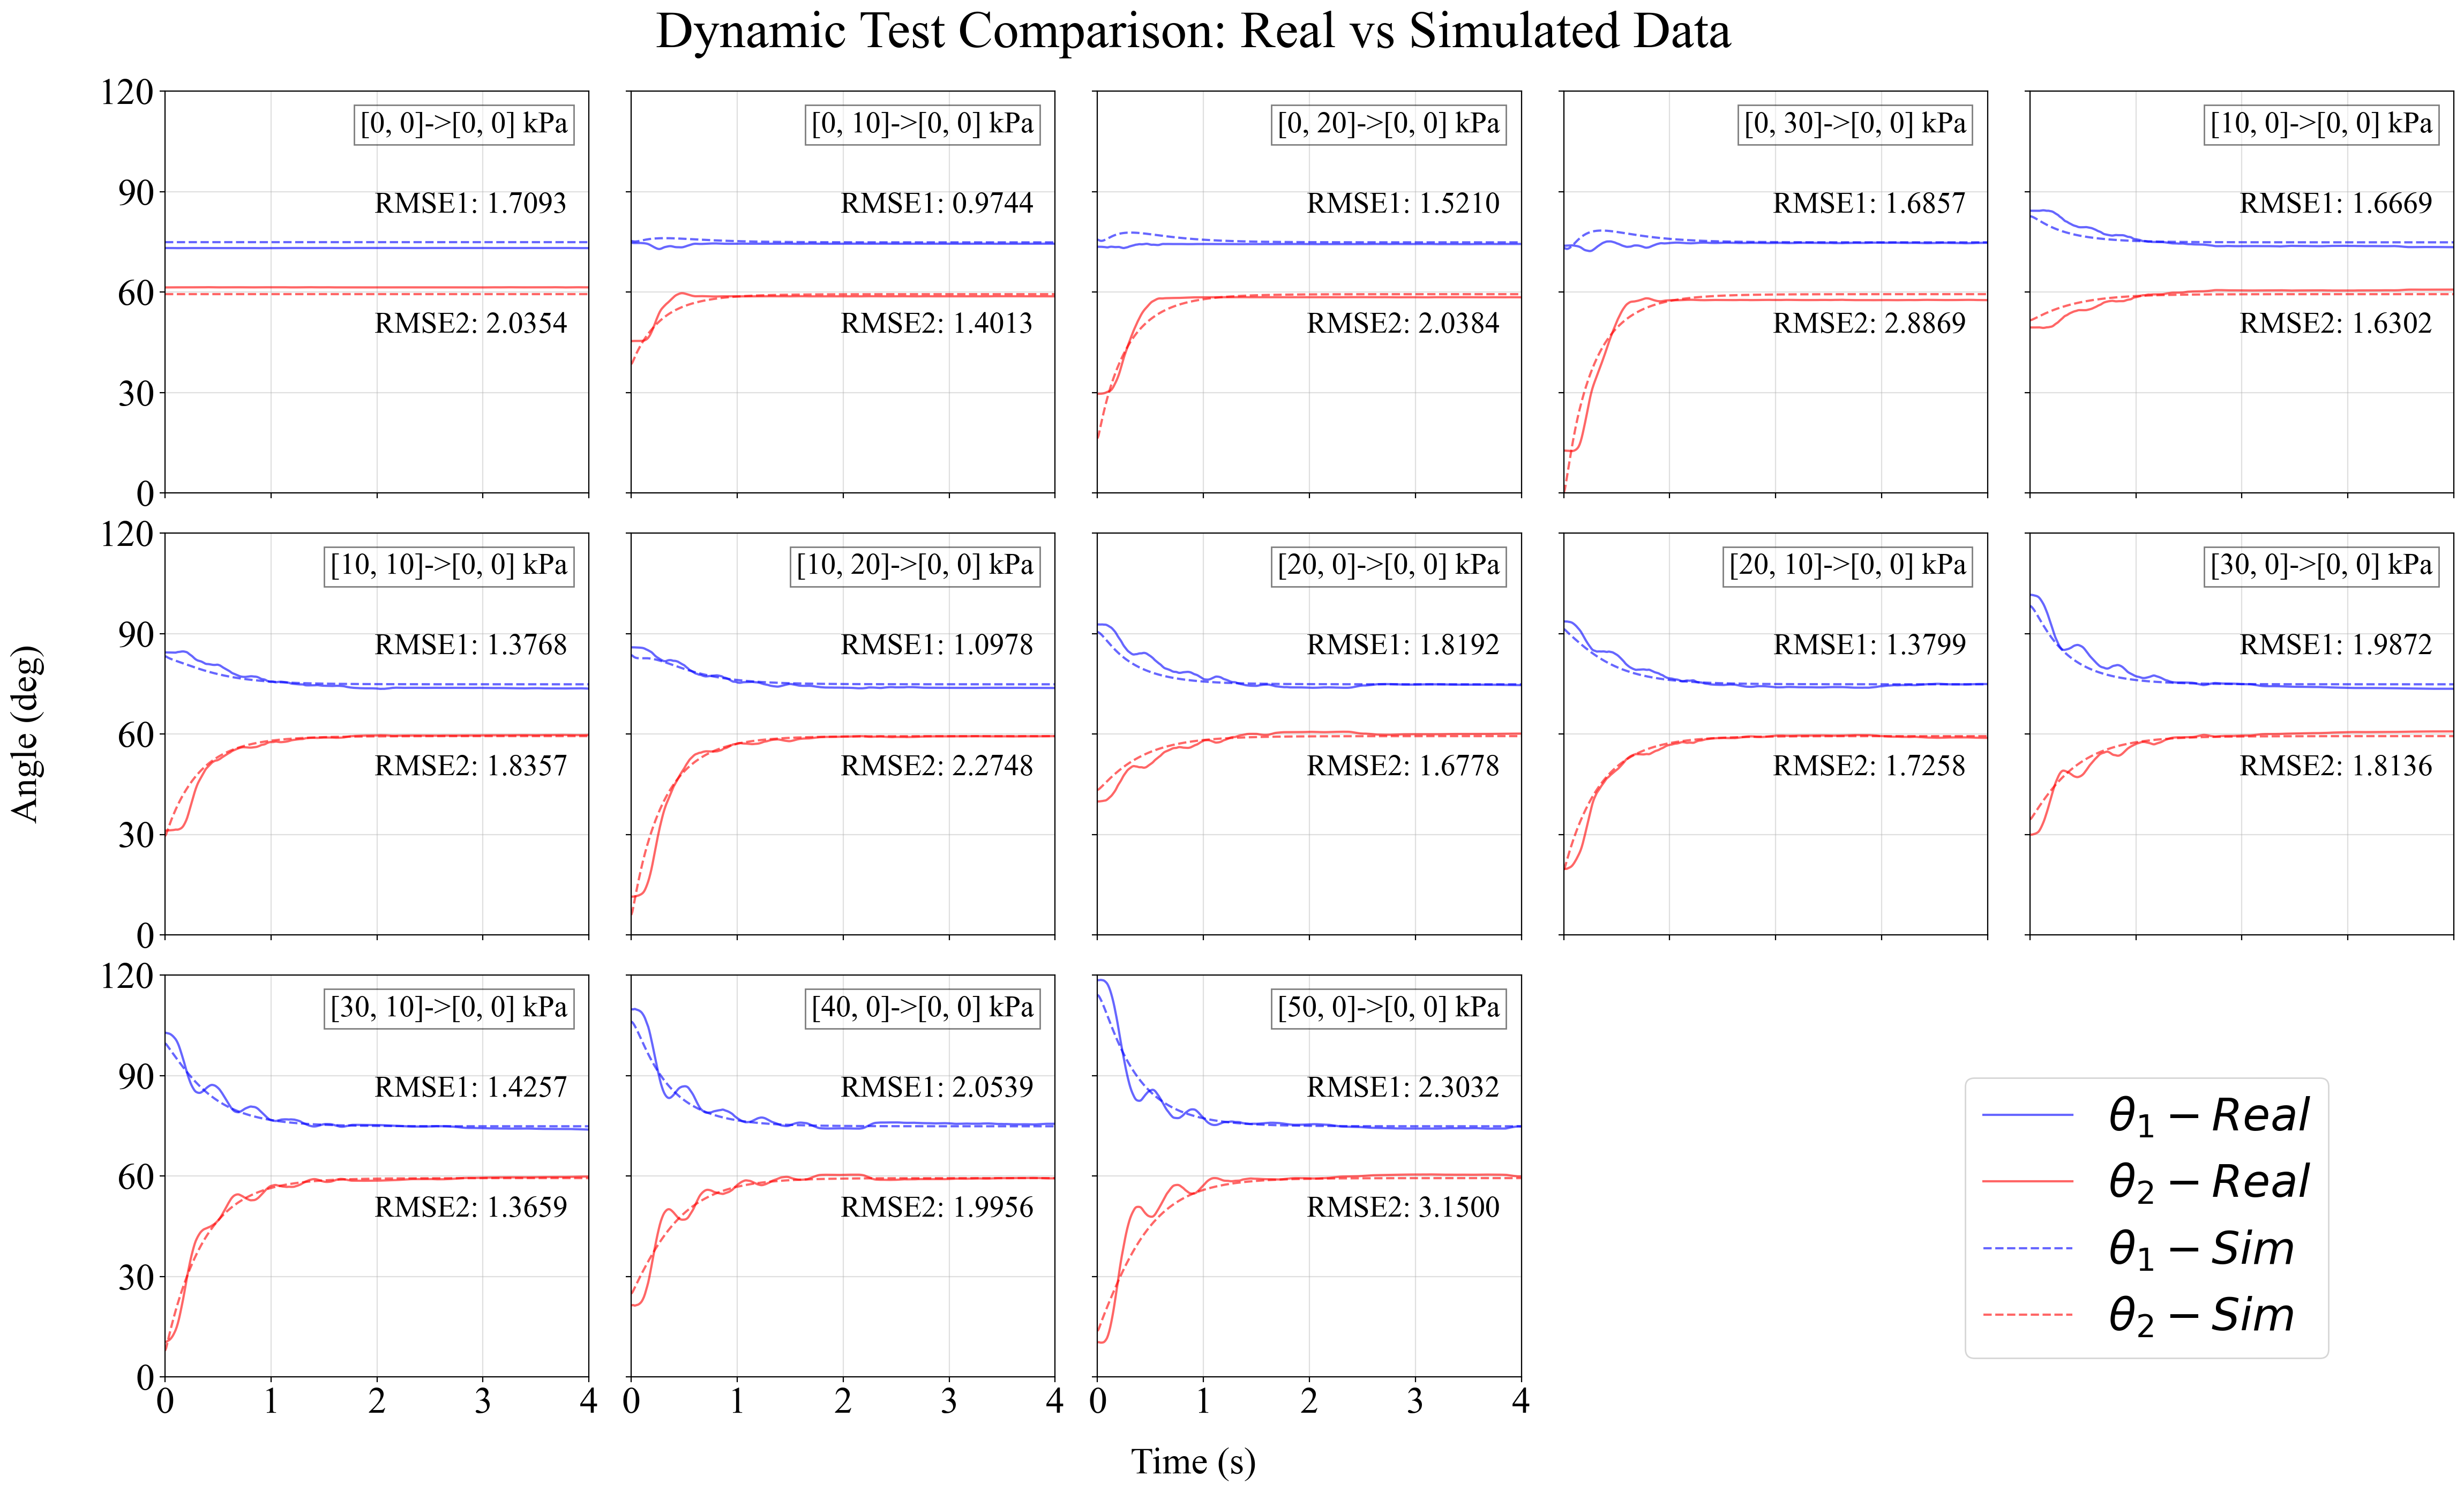

In [19]:
# draw the comparison
num_experiments = len(expdata_real_lineInterp_effective_smooth)
ncols = 5  
nrows = math.ceil(num_experiments / ncols) 

from matplotlib import rcParams

config = {
    "font.family":'Times New Roman', 
    "axes.unicode_minus": False,
    "font.size": 16, 
}
rcParams.update(config)

legendSet = {
    # 'loc': 'upper right',
    'fontsize': 30,
}

axisSet = {
    'fontsize': 25,
}

textSet = {
    'fontsize': 20,
}

titleSet = {
    'fontsize': 35,
}

fig = plt.figure(figsize=(24, 15), dpi=200)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.1, left=0.1, right=0.99, top=0.9, bottom=0.1)

for exp_id in range(num_experiments):
    ax = fig.add_subplot(gs[exp_id // ncols, exp_id % ncols])
    expdata_real, expdata_sim = expdata_real_lineInterp_effective_smooth[exp_id], expdata_sim_all[exp_id]
    if exp_id == 0:
        ax.plot(expdata_real[0], expdata_real[1], label=r"$\theta_1-Real$", color='blue', linestyle='-', alpha=0.6)
        ax.plot(expdata_real[0], expdata_real[2], label=r"$\theta_2-Real$", color='red', linestyle='-', alpha=0.6)
        ax.plot(expdata_sim[0], expdata_sim[1]*180/math.pi, label=r"$\theta_1-Sim$", color='blue', linestyle='--', alpha=0.6)
        ax.plot(expdata_sim[0], expdata_sim[2]*180/math.pi, label=r"$\theta_2-Sim$", color='red', linestyle='--', alpha=0.6)
    else:
        ax.plot(expdata_real[0], expdata_real[1], color='blue', linestyle='-', alpha=0.6)
        ax.plot(expdata_real[0], expdata_real[2], color='red', linestyle='-', alpha=0.6)
        ax.plot(expdata_sim[0], expdata_sim[1]*180/math.pi, color='blue', linestyle='--', alpha=0.6)
        ax.plot(expdata_sim[0], expdata_sim[2]*180/math.pi, color='red', linestyle='--', alpha=0.6)
    # ax.set_title(f"Experiment {exp_id + 1}")
    ax.text(0.95, 0.95, f'[{int(P1_array[exp_id]/1000):d}, {int(P2_array[exp_id]/1000):d}]->[0, 0] kPa', transform=ax.transAxes, 
            ha='right', va='top', fontsize=textSet['fontsize'], bbox=dict(facecolor='white', alpha=0.5))
    # text: RMSE
    RMSE_THETA1 = np.sqrt(np.mean((expdata_real[1]-expdata_sim[1]*180/math.pi)**2))
    RMSE_THETA2 = np.sqrt(np.mean((expdata_real[2]-expdata_sim[2]*180/math.pi)**2))
    ax.text(0.95, 0.75, f"RMSE1: {RMSE_THETA1:.4f}", transform=ax.transAxes, 
            ha='right', va='top', fontsize=textSet['fontsize'])
    ax.text(0.95, 0.45, f"RMSE2: {RMSE_THETA2:.4f}", transform=ax.transAxes,
            ha='right', va='top', fontsize=textSet['fontsize'])
    
    ax.grid(alpha=0.4) 
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 120) 
    ax.set_xticks(np.arange(0, 4.1, 1))  
    ax.set_yticks(np.arange(0, 120.1, 30)) 
    ax.tick_params(axis='both', labelsize=axisSet['fontsize'])  # 12
    if exp_id%ncols != 0:   
        ax.set_yticklabels([]) 
    if exp_id//ncols != nrows-1:  
        ax.set_xticklabels([]) 

fig.text(0.5, 0.04, 'Time (s)', ha='center', fontsize=axisSet['fontsize'])
fig.text(0.04, 0.5, 'Angle (deg)', va='center', rotation='vertical', fontsize=axisSet['fontsize'])

fig.suptitle('Dynamic Test Comparison: Real vs Simulated Data', fontsize=titleSet['fontsize'], y=0.95)

handles, labels = [], []
for ax in fig.axes:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
fig.legend(handles, labels, bbox_to_anchor=(0.95, 0.3), ncol=1, fontsize=legendSet['fontsize'])

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

